# Table of contents
1. Importing the data
2. Initial EDA
3. Train/Test split
4. EDA
5. Similarity check
6. Data cleaning
7. Train/Test analysis
8. Modelling
9. Hyperparameter tuning for RF
10. Hyperparameter tuning for LR
11. Hyperparameter tuning for SVM

# Importing the data

In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [5]:
df= pd.read_csv('/data/DS_INTERN/data/RAW_DATA/train_test_data.csv', low_memory=False)

In [6]:
df.head()

,Unnamed: 0,COUNTRY_CODE,DEPT_NBR,DEPT_DESC,MDS_FAM_ID,UPC_DESC,CATG_DESC,SUBCATG_DESC,FINELINE_DESC,SIGNING_DESC,ITEM1_DESC,ITEM2_DESC,SBU,SP_CLASS,FEAT1,REVISED_CATEGORY,REVISED_VARIETY
0,6241827,US,94,PRODUCE,42706762,UPC,FASTENER,TWISTTIE RUBBERBANDS,1036 TWISTTIE RUBBAN FOOD,NaN,TIE 18 ESCAROLE SM,SC NHM,FOOD,PRODUCE & FLOWERS,TIE 18 ESCAROLE SM SC NHM UPC FASTENER TWISTTI...,NaN,NaN
1,6241828,US,94,PRODUCE,91580188,ODW BRSGOMEG,PREMIUM BEVERAGE,SUPER PREMIUM BEVERAGE,POM,ODWALLA BERRY GO MEGA 12OZ,JUICE BRY OMEGA 12FO O,ODW BERRY GOMEGA,FOOD,PRODUCE & FLOWERS,ODWALLA BERRY GO MEGA 12OZ JUICE BRY OMEGA 12F...,NaN,NaN
2,6241829,US,94,PRODUCE,86896524,NECTOR,PREMIUM BEVERAGE,SUPER PREMIUM BEVERAGE,POM,ODWALLA C MONSTER NECTAR 12FO,ODW C MONSTER 12OZ,ODWALLA,FOOD,PRODUCE & FLOWERS,ODWALLA C MONSTER NECTAR 12FO ODW C MONSTER 12...,NaN,NaN
3,6241830,US,94,PRODUCE,91580181,JUICE,PREMIUM BEVERAGE,SUPER PREMIUM BEVERAGE,POM,ODWALLA ORANGE JUICE,JUICE OJ 12 FO O,ODW OJ,FOOD,PRODUCE & FLOWERS,ODWALLA ORANGE JUICE JUICE OJ 12 FO O ODW OJ J...,NaN,NaN
4,6241831,US,94,PRODUCE,91988756,RASP LMNGRS,PREMIUM BEVERAGE,SUPER PREMIUM BEVERAGE,POM,RAAW JUICE RASPBERRY LEMONGRASS,RAAW RASP LEMNGRS,NaN,FOOD,PRODUCE & FLOWERS,RAAW JUICE RASPBERRY LEMONGRASS RAAW RASP LEMN...,NaN,NaN


# Initial EDA

In [7]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))

In [8]:
initial_eda(df)

Dimensions : 296405 rows, 17 columns
Total NA Values : 528654 
                           Column Name  Data Type      #Distinct  NA Values
                            Unnamed: 0      int64       296405          0
                          COUNTRY_CODE     object           10          0
                              DEPT_NBR      int64           18          0
                             DEPT_DESC     object           25          0
                            MDS_FAM_ID      int64       295668          0
                              UPC_DESC     object        22029         20
                             CATG_DESC     object          369          0
                          SUBCATG_DESC     object          705          0
                         FINELINE_DESC     object         2578          1
                          SIGNING_DESC     object        42959       1294
                            ITEM1_DESC     object        64071          0
                            ITEM2_DESC     obje

In [9]:
# Test data = 296405 - 48197 = 248208
# Train data = 296405 - 248208 = 48197

r = 248208/48197
print('Test to Training data ratio is {:0.2f}'.format(r))

Test to Training data ratio is 5.15


In [10]:
df1 = df[['COUNTRY_CODE','FEAT1','REVISED_CATEGORY','REVISED_VARIETY']]

In [11]:
df1.head()

,COUNTRY_CODE,FEAT1,REVISED_CATEGORY,REVISED_VARIETY
0,US,TIE 18 ESCAROLE SM SC NHM UPC FASTENER TWISTTI...,NaN,NaN
1,US,ODWALLA BERRY GO MEGA 12OZ JUICE BRY OMEGA 12F...,NaN,NaN
2,US,ODWALLA C MONSTER NECTAR 12FO ODW C MONSTER 12...,NaN,NaN
3,US,ODWALLA ORANGE JUICE JUICE OJ 12 FO O ODW OJ J...,NaN,NaN
4,US,RAAW JUICE RASPBERRY LEMONGRASS RAAW RASP LEMN...,NaN,NaN


In [12]:
df['COUNTRY_CODE'].describe()

count     296405
unique        10
top           CN
freq      163262
Name: COUNTRY_CODE, dtype: object

In [13]:
df['COUNTRY_CODE'].value_counts()

CN    163262
US     59398
CA     25467
JP     15566
MX     10313
SM      6447
K2      5362
K1      4213
AR      3641
GB      2736
Name: COUNTRY_CODE, dtype: int64

/base_env/py3-anaconda-base/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


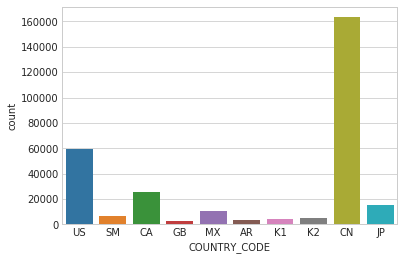

In [14]:
sns.countplot(x='COUNTRY_CODE',data=df)

In [15]:
m1 = df['REVISED_CATEGORY'].isna()
m2 = df['REVISED_VARIETY'].isna()

df['TARGET'] = np.select([m1, m2, m1 & m2], 
                        [df['REVISED_CATEGORY'], df['REVISED_VARIETY'], np.nan], 
                        default=df['REVISED_CATEGORY'] + '_' + df['REVISED_VARIETY'])

# Dividing intro Training and Test data

In [16]:
train_df = df[['COUNTRY_CODE','FEAT1','TARGET']].dropna()

In [17]:
test_df = df[df['TARGET'].isna()][['COUNTRY_CODE','FEAT1','TARGET']]

# EDA

In [18]:
train_df['word_count'] = train_df['FEAT1'].apply(lambda x : len(x.split()))
train_df['char_count'] = train_df['FEAT1'].apply(lambda x : len(x.replace(" ","")))

In [19]:
test_df['word_count'] = test_df['FEAT1'].apply(lambda x : len(x.split()))
test_df['char_count'] = test_df['FEAT1'].apply(lambda x : len(x.replace(" ","")))

In [20]:
train_df.head()

,COUNTRY_CODE,FEAT1,TARGET,word_count,char_count
8,US,BHF VANILLA CHAI LATTE 52OZ 52OZ VANILLA CHAI ...,BEVERAGES_BOLTHOUSE JUICE,22,113
9,US,ENERGY ACAI BERRY JUICE 1L SAM ENERGY 33 8FO J...,BEVERAGES_BOLTHOUSE JUICE,18,92
10,US,GENESIS TODAY POM BERRY 59OZ GT POM BERRY 59OZ...,BEVERAGES_BOLTHOUSE JUICE,20,106
11,US,PEPPERMINT MOCHA 52FO BHF PEPMINT MOCHA PEPPER...,BEVERAGES_BOLTHOUSE JUICE,17,111
12,US,SAMBAZON 100 ACAI BERRY 1L 8 PACK SAM 100CAL A...,BEVERAGES_BOLTHOUSE JUICE,21,99


In [21]:
test_df.head()

,COUNTRY_CODE,FEAT1,TARGET,word_count,char_count
0,US,TIE 18 ESCAROLE SM SC NHM UPC FASTENER TWISTTI...,NaN,14,72
1,US,ODWALLA BERRY GO MEGA 12OZ JUICE BRY OMEGA 12F...,NaN,21,103
2,US,ODWALLA C MONSTER NECTAR 12FO ODW C MONSTER 12...,NaN,17,91
3,US,ODWALLA ORANGE JUICE JUICE OJ 12 FO O ODW OJ J...,NaN,17,78
4,US,RAAW JUICE RASPBERRY LEMONGRASS RAAW RASP LEMN...,NaN,15,91


In [22]:
train_df['FEAT1'].describe()

count                                                 48197
unique                                                26796
top       FRESH GROWN YELLOW PEACH PEACH YELLOW DSD SECO...
freq                                                    103
Name: FEAT1, dtype: object

In [23]:
test_df['FEAT1'].describe()

count                                                248208
unique                                               109341
top       BLUEBERRY 170 GR BLUEBERRY 170GR PACKAGED BLUE...
freq                                                    509
Name: FEAT1, dtype: object

In [24]:
train_df['COUNTRY_CODE'].value_counts(normalize=True)

US    0.998651
CA    0.001328
SM    0.000021
Name: COUNTRY_CODE, dtype: float64

In [25]:
test_df['COUNTRY_CODE'].value_counts(normalize=True)

CN    0.657763
CA    0.102346
JP    0.062714
US    0.045389
MX    0.041550
SM    0.025970
K2    0.021603
K1    0.016974
AR    0.014669
GB    0.011023
Name: COUNTRY_CODE, dtype: float64

In [26]:
train_df['avg_word_length'] = train_df['char_count'] / (train_df['word_count'] )
test_df['avg_word_length'] = test_df['char_count'] / (test_df['word_count'] )


# Word density is no. of words per character

In [27]:
train_df.describe()

,word_count,char_count,avg_word_length
count,48197.000000,48197.000000,48197.000000
mean,16.761852,80.666722,4.928264
std,3.542114,15.046656,0.981112
min,6.000000,32.000000,2.700000
25%,14.000000,70.000000,4.235294
50%,17.000000,80.000000,4.764706
75%,19.000000,91.000000,5.533333
max,30.000000,155.000000,9.000000


In [28]:
test_df.describe()

,word_count,char_count,avg_word_length
count,248208.000000,248208.000000,248208.000000
mean,17.397493,90.805308,5.262910
std,4.132093,22.335596,0.757779
min,2.000000,11.000000,2.400000
25%,15.000000,75.000000,4.750000
50%,17.000000,90.000000,5.214286
75%,20.000000,107.000000,5.700000
max,36.000000,196.000000,10.666667


/base_env/py3-anaconda-base/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


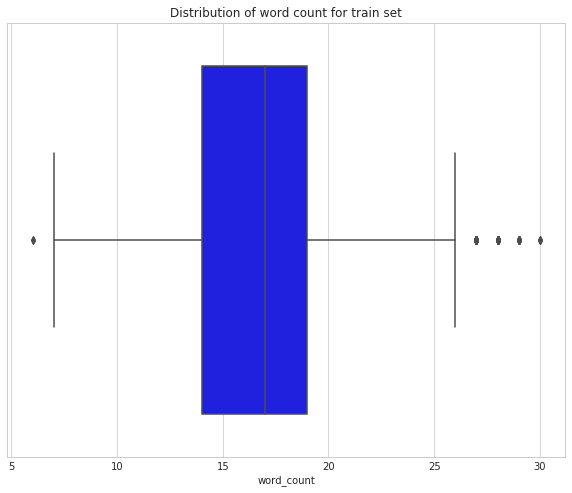

In [29]:
f, ax = plt.subplots(figsize=(10,8))
x = train_df['word_count'].astype('float64')

ax = sns.boxplot(x, color='blue')
ax.set_title("Distribution of word count for train set")
plt.show()

/base_env/py3-anaconda-base/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


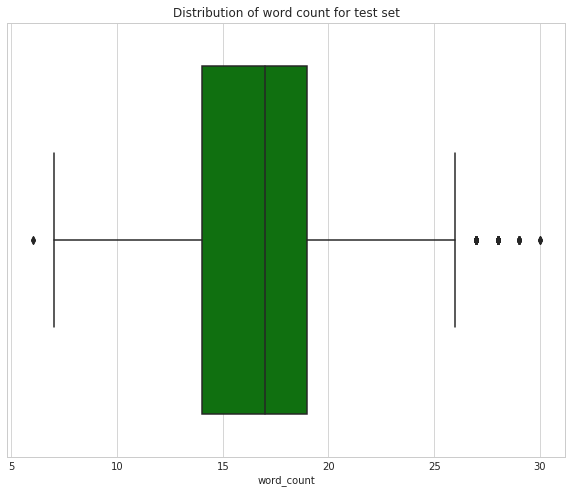

In [30]:
f, ax = plt.subplots(figsize=(10,8))
x = train_df['word_count'].astype('float64')

ax = sns.boxplot(x, color='green')
ax.set_title("Distribution of word count for test set")
plt.show()

In [31]:
# correlation heatmap

train_df.corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,word_count,char_count,avg_word_length
word_count,1.0,0.5494,-0.5583
char_count,0.5494,1.0,0.3625
avg_word_length,-0.5583,0.3625,1.0


In [32]:
test_df.corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,word_count,char_count,avg_word_length
word_count,1.0,0.8426,-0.2415
char_count,0.8426,1.0,0.2966
avg_word_length,-0.2415,0.2966,1.0


In [33]:
train_df['TARGET'].value_counts(normalize=True).head(10)

BLUEBERRIES_BLUEBERRIES    0.022699
CITRUS_ORANGES - OTHER     0.021391
AVOCADOES_AVOCADOES        0.018839
POTATOES_POTATO RUSSET     0.016350
TOMATOES_TOMATO SLICERS    0.015499
CORN_CORN                  0.015312
APPLES_GALA                0.015250
BERRIES_STRAWBERRIES       0.014586
SNACKS_SNACKS              0.013486
SALADS_SALADS KITS         0.011909
Name: TARGET, dtype: float64

In [34]:
train_df.groupby('TARGET').describe()[['char_count','word_count']].mean

<bound method DataFrame.mean of                                            char_count                         \
                                                count        mean        std   
TARGET                                                                         
ALOE VERA_ALOE VERA                              82.0   77.378049   5.017599   
APPLE CIDER_APPLE CIDER                         165.0   81.339394  11.638612   
APPLE CIDER_APPLE MIXES                          19.0   74.947368   3.324550   
APPLE CIDER_APPLES CARAMEL                      155.0   96.458065  10.542578   
APPLES_AMBROSIA                                  85.0   81.670588   4.721754   
APPLES_BRAEBURN                                  92.0   81.000000   5.556898   
APPLES_CORTLAND                                  49.0   85.265306   8.343599   
APPLES_COSMIC CRISP                              79.0   83.569620   7.647161   
APPLES_EMPIRE                                    59.0   73.067797   5.927331   
APPLES_E

# Jaccard Similarity
# Creating a list of all the words in the FEAT1 column

In [35]:
train_list_words = ' '.join([i for i in train_df['FEAT1']]).split()
test_list_words = ' '.join([i for i in test_df['FEAT1']]).split()

In [36]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

In [37]:
jaccard_similarity(train_list_words, test_list_words)

0.11572177911906302

In [38]:
intersection = set(train_list_words).intersection(set(test_list_words))
union = set(train_list_words).union(set(test_list_words))
print("No. of common words:",len(intersection)) 
print('No. of words in the union:',len(union))

No. of common words: 3221
No. of words in the union: 27834


In [39]:
set1 = set(train_list_words)
set2 = set(test_list_words)

A1 = list(sorted(set1 - set2)) #only the words not in set2 will be left
A2 = list(sorted(set2 - set1)) #only the words not in set1 will be left


In [40]:
print('Words missing in train set: \n', A1)

Words missing in train set: 
 ['06OZ', '06Z', '06ZCF', '0G', '100BULK', '100CAL', '100FL', '100PC', '100Z', '104PCMIX', '105CT', '108CT', '10BR', '10EC', '10MX', '10SZ', '10X', '110CT', '112CT', '115CT', '115PC', '115SZ', '117SZ', '11CT', '11WA', '120CT', '120FL', '120NY', '120PC', '120WA', '120Z', '125PC', '126', '128FO', '128PC', '12AG', '12AW', '12C', '12CP', '12DC', '12DM', '12DSD', '12FL', '12KA', '12KF', '12MF', '12OZFE', '12PACK', '12PCSLDPIZ', '12SW', '12SZ', '12X1', '12ZCF', '12ZHM', '12ZHT', '13CP', '13CT', '140CT', '140PC', '14BR', '14CT', '14MX', '14SZ', '14X3', '14ZCF', '150PC', '154PCHARVEST', '15C', '15SW', '160PC', '160Z', '165PC', '16CA', '16OZNAS', '16SZ', '16ZCA', '16ZDSD', '16ZFRO', '16ZOZ', '16ZRFG', '170PC', '175CT', '175SZ', '17FO', '17Z', '180PC', '183PC', '18CA', '18FO', '18PC', '18SW', '18SZ', '190PC', '192PC', '1CA', '1LBS', '1O', '200CT', '200PC', '2018', '2071', '2074', '20BR', '20OZF', '20SZ', '20TYPE', '20X2LB', '210PC', '216PC', '2188', '220PC', '225PC',

In [41]:
print('Words missing in test set:\n', A2)

Words missing in test set:
 ['000G', '0028B', '006ALBAHACA', '010APIO', '014BATATA', '017BROCOLI', '021ZEBOLLA', '022EBOLLAVERDEO', '027CHOCLO', '034PARRAGOS', '035ESPINACA', '051MANDARINA', '056NARANJA', '058NUECES', '05GINSTA', '063PEPINO', '065PEREJIL', '068PORT', '06L', '07KG', '096MARACUYA', '09P', '0GRANNY', '0M', '0NZ', '1000', '1000CT', '1001', '1003', '1007', '1008', '1009', '100ASST', '100BLOOMS', '100G', '100GR', '100LB', '100ST', '100STEM', '100STEMS', '100YD', '101', '1011', '1012', '1013', '1014', '1016', '1017', '1018', '1019', '101OZ', '102', '1020', '1022', '1023', '1025', '1026', '1027', '1028', '1029', '102CILANDRO', '102OZ', '102P', '102PC4', '102PCFP', '103', '1030', '1030GR', '1031', '1033', '1034', '1035', '1036', '1038', '1039', '104', '1040', '1041', '1043', '1045', '1046', '1047', '1048', '1049', '104OZ', '104PCCDAY', '104PCRUSTIC', '1050', '1052', '1054', '1057', '1059', '105G', '105OZ', '106', '1060', '1060ML', '1062', '1064', '1065', '1067', '1068', '1069',

In [42]:
print("No of words NOT in TRAIN SET but IN TEST SET:",len(A1))
print("No of words NOT in TEST SET but IN TRAIN SET:",len(A2))

No of words NOT in TRAIN SET but IN TEST SET: 2659
No of words NOT in TEST SET but IN TRAIN SET: 21954


# Cossine Similarity
# Joining all the FEAT1 values to form a single sentence

In [43]:
train_text = ' '.join(train_df.FEAT1)
test_text = ' '.join(test_df.FEAT1)


In [44]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer()
cv = CountVectorizer()

p = [train_text, test_text ]

cd_tfidf = cosine_distances(tfidf.fit_transform(p))
cd_cv = cosine_distances(cv.fit_transform(p))

# We can see this as a similarity between 2 sentences
# Its is forming a bag of words, and then creating
# a vector for each sentence.

In [45]:
print('Similarity of two texts using TF-IDF is equal to ',round((1-cd_tfidf[0][1])*100,2),'%')
print('Similarity of two texts using Count Vect is equal to ',round((1-cd_cv[0][1])*100,2),'%')

Similarity of two texts using TF-IDF is equal to  33.73 %
Similarity of two texts using Count Vect is equal to  34.03 %


In [46]:
print(len(tfidf.get_feature_names()),len(cv.get_feature_names()))

27800 27800


In [47]:
help(CountVectorizer())

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  Convert a collection of text documents to a matrix of token counts
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----------
 |  input : {'filename', 'file', 'content'}, default='content'
 |      - If `'filename'`, the sequence passed as an argument to fit is
 |        expected to be a list of filenames that need reading to fetch
 |        the raw content to analyze.
 |  
 |      - If `'file'`, the sequence items must have a 'read' method (file-like
 |        ob

In [48]:
tfidf.get_feature_names()

['000g',
 '0028b',
 '006albahaca',
 '010apio',
 '014batata',
 '017brocoli',
 '021zebolla',
 '022ebollaverdeo',
 '027choclo',
 '034parragos',
 '035espinaca',
 '051mandarina',
 '056naranja',
 '058nueces',
 '05ginsta',
 '063pepino',
 '065perejil',
 '068port',
 '06l',
 '06oz',
 '06z',
 '06zcf',
 '07kg',
 '096maracuya',
 '09p',
 '0g',
 '0granny',
 '0m',
 '0nz',
 '0oz',
 '0z',
 '10',
 '100',
 '1000',
 '1000ct',
 '1001',
 '1003',
 '1007',
 '1008',
 '1009',
 '100asst',
 '100blooms',
 '100bulk',
 '100cal',
 '100ct',
 '100fl',
 '100g',
 '100gr',
 '100lb',
 '100pc',
 '100st',
 '100stem',
 '100stems',
 '100yd',
 '100z',
 '101',
 '1011',
 '1012',
 '1013',
 '1014',
 '1015',
 '1016',
 '1017',
 '1018',
 '1019',
 '101oz',
 '102',
 '1020',
 '1022',
 '1023',
 '1025',
 '1026',
 '1027',
 '1028',
 '1029',
 '102cilandro',
 '102oz',
 '102p',
 '102pc4',
 '102pcfp',
 '103',
 '1030',
 '1030gr',
 '1031',
 '1033',
 '1034',
 '1035',
 '1036',
 '1038',
 '1039',
 '104',
 '1040',
 '1041',
 '1043',
 '1045',
 '1046',
 '1

In [49]:
u = set(train_text.split()).union(set(test_text.split()))
len(u)

27834

In [50]:
len(list((set(u)-set(tfidf.get_feature_names()))))

26748

In [51]:
from collections import Counter

freq_train = Counter(train_text.split())

{k: v for k, v in sorted(freq_train.items(), key=lambda item: item[1], reverse=True)}

{'APPLE': 35518,
 'BULK': 25038,
 'BAG': 17815,
 'SALAD': 12869,
 '3': 12857,
 'GRAPE': 12607,
 'RED': 12557,
 'ORGANIC': 12020,
 'GREEN': 12005,
 'POTATO': 11200,
 'ONION': 9972,
 'ORANGE': 9728,
 'TOMATO': 9567,
 'ORG': 9490,
 'FRESH': 9385,
 'DSD': 9138,
 'PEPPER': 8546,
 '2': 7750,
 'BLUEBERRY': 7519,
 'PEAR': 7350,
 'YELLOW': 7322,
 'AVOCADO': 7246,
 'L4': 7061,
 'BELL': 6792,
 '5': 6580,
 'L3': 6536,
 'SUPPLIER': 6428,
 'SECONDARY': 6425,
 'WATERMELON': 6390,
 '1': 6082,
 'LB': 5746,
 'SQUASH': 5541,
 'FRUIT': 5430,
 'WHITE': 5096,
 'CORN': 4875,
 'SEEDLESS': 4769,
 'STRAWBERRY': 4341,
 'LETTUCE': 4282,
 'CHILI': 4262,
 'PKG': 4188,
 'CUT': 4052,
 'PEACH': 3936,
 '6OZ': 3841,
 'OZ': 3800,
 'PUMPKIN': 3797,
 'CARROT': 3736,
 'VEG': 3483,
 'MUSHROOM': 3473,
 'NECTARINE': 3439,
 'SWEET': 3367,
 'VEGETABLE': 3326,
 'CA': 3246,
 'GALA': 3131,
 'LEMON': 3099,
 'CELERY': 2982,
 'PINEAPPLE': 2971,
 'CUCUMBER': 2967,
 '4': 2962,
 'RUSSET': 2919,
 'MANGO': 2904,
 'BROCCOLI': 2877,
 'GRAPEF

In [52]:
freq_test = Counter(test_text.split())

{k: v for k, v in sorted(freq_test.items(), key=lambda item: item[1], reverse=True)}

{'FRUIT': 317263,
 'DOMESTIC': 169922,
 'VEGETABLE': 139102,
 'IMPORT': 100498,
 'PACK': 91514,
 'BULK': 86620,
 'CITRUS': 82985,
 'SOFT': 69263,
 'VEG': 64073,
 'POME': 58055,
 'BOX': 58037,
 'PACKAGED': 52720,
 'RED': 50325,
 'HO': 45312,
 'ORANGE': 43534,
 'IMPORTED': 43510,
 'MELON': 43233,
 'TROPICAL': 43004,
 'STONE': 41502,
 'GREEN': 38796,
 'APPLE': 37400,
 'D': 36405,
 'S': 32072,
 'FDC': 27978,
 'MUSHROOM': 26789,
 'GRAPE': 26537,
 'GRAPEFRUIT': 25648,
 'PEAR': 25419,
 'BAG': 23603,
 'PEACH': 22939,
 'KIWI': 20980,
 'L': 20296,
 'M': 19834,
 'TOMATO': 19026,
 'BEAN': 17849,
 'POTATO': 17654,
 'PEPPER': 17632,
 'MANGO': 17580,
 'WHITE': 17460,
 'LEAF': 17067,
 'CHERRY': 16974,
 'FLOWER': 16013,
 'ORGANIC': 15896,
 'CAR': 14702,
 'FOOD': 13745,
 'SWEET': 13742,
 'ONION': 13696,
 'GRAIN': 13667,
 'GIFT': 13288,
 'FRESH': 13269,
 'HONEY': 13039,
 'GOLDEN': 12979,
 'YELLOW': 12559,
 'SALAD': 12531,
 'ROOT': 12361,
 'EGG': 12312,
 'DRAGON': 12148,
 'DRY': 11961,
 'WATERMELON': 1165

# Data Cleaning

In [53]:
X_train = train_df['FEAT1']
Y_train = train_df['TARGET']

X_test = test_df['FEAT1']

In [54]:
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.
stop_words = stopwords.words('english')

from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
def preprocess(sentence):
    return [w.upper() for w in sentence.lower().split() if w not in stop_words]

In [56]:
update_train_text = preprocess(train_text)

# update_train_text is a list of all the words after stopwords removal

In [57]:
print('Initial no. of words in training data:',train_df['word_count'].sum())

Initial no. of words in training data: 807871


In [58]:
print('No. of words after removal of stopwords from train data:',len(update_train_text))

No. of words after removal of stopwords from train data: 805634


In [59]:
1-len(update_train_text)/train_df['word_count'].sum()

0.002769006437909005

In [60]:
X_train_df = pd.DataFrame(X_train)

X_train_df['FEAT1_without_stopwords'] = X_train_df['FEAT1'].apply(lambda x: ' '.join([word.upper() for word in x.lower().split() if word not in (stop_words)]))
#test['tweet'].apply(lambda x: [item for item in x if item not in stop])

In [61]:
X_train_df.head()

,FEAT1,FEAT1_without_stopwords
8,BHF VANILLA CHAI LATTE 52OZ 52OZ VANILLA CHAI ...,BHF VANILLA CHAI LATTE 52OZ 52OZ VANILLA CHAI ...
9,ENERGY ACAI BERRY JUICE 1L SAM ENERGY 33 8FO J...,ENERGY ACAI BERRY JUICE 1L SAM ENERGY 33 8FO J...
10,GENESIS TODAY POM BERRY 59OZ GT POM BERRY 59OZ...,GENESIS TODAY POM BERRY 59OZ GT POM BERRY 59OZ...
11,PEPPERMINT MOCHA 52FO BHF PEPMINT MOCHA PEPPER...,PEPPERMINT MOCHA 52FO BHF PEPMINT MOCHA PEPPER...
12,SAMBAZON 100 ACAI BERRY 1L 8 PACK SAM 100CAL A...,SAMBAZON 100 ACAI BERRY 1L 8 PACK SAM 100CAL A...


# Lemmatization

In [62]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [63]:
import nltk
nltk.set_proxy("http://sysproxy.wal-mart.com:8080")

In [64]:
# TOKENIZATION
tt = TweetTokenizer()
X_train_df['tokenised_FEAT1_without_stopwords'] = X_train_df['FEAT1_without_stopwords'].apply(tt.tokenize)
(X_train_df)

# LEMMATIZATION
lmtzr = WordNetLemmatizer()
X_train_df['lemmatize'] = X_train_df['tokenised_FEAT1_without_stopwords'].apply(
                             lambda lst:[lmtzr.lemmatize(word.lower()).upper() for word in lst])

In [65]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
# ABBREVIATIONS


In [67]:
X_train_df['FEAT1_without_stopwords_lemmatized'] = X_train_df['lemmatize'].apply(lambda x: ' '.join([word for word in x]))
X_train_df

,FEAT1,FEAT1_without_stopwords,tokenised_FEAT1_without_stopwords,lemmatize,FEAT1_without_stopwords_lemmatized
8,BHF VANILLA CHAI LATTE 52OZ 52OZ VANILLA CHAI ...,BHF VANILLA CHAI LATTE 52OZ 52OZ VANILLA CHAI ...,"[BHF, VANILLA, CHAI, LATTE, 52OZ, 52OZ, VANILL...","[BHF, VANILLA, CHAI, LATTE, 52OZ, 52OZ, VANILL...",BHF VANILLA CHAI LATTE 52OZ 52OZ VANILLA CHAI ...
9,ENERGY ACAI BERRY JUICE 1L SAM ENERGY 33 8FO J...,ENERGY ACAI BERRY JUICE 1L SAM ENERGY 33 8FO J...,"[ENERGY, ACAI, BERRY, JUICE, 1L, SAM, ENERGY, ...","[ENERGY, ACAI, BERRY, JUICE, 1L, SAM, ENERGY, ...",ENERGY ACAI BERRY JUICE 1L SAM ENERGY 33 8FO J...
10,GENESIS TODAY POM BERRY 59OZ GT POM BERRY 59OZ...,GENESIS TODAY POM BERRY 59OZ GT POM BERRY 59OZ...,"[GENESIS, TODAY, POM, BERRY, 59OZ, GT, POM, BE...","[GENESIS, TODAY, POM, BERRY, 59OZ, GT, POM, BE...",GENESIS TODAY POM BERRY 59OZ GT POM BERRY 59OZ...
11,PEPPERMINT MOCHA 52FO BHF PEPMINT MOCHA PEPPER...,PEPPERMINT MOCHA 52FO BHF PEPMINT MOCHA PEPPER...,"[PEPPERMINT, MOCHA, 52FO, BHF, PEPMINT, MOCHA,...","[PEPPERMINT, MOCHA, 52FO, BHF, PEPMINT, MOCHA,...",PEPPERMINT MOCHA 52FO BHF PEPMINT MOCHA PEPPER...
12,SAMBAZON 100 ACAI BERRY 1L 8 PACK SAM 100CAL A...,SAMBAZON 100 ACAI BERRY 1L 8 PACK SAM 100CAL A...,"[SAMBAZON, 100, ACAI, BERRY, 1L, 8, PACK, SAM,...","[SAMBAZON, 100, ACAI, BERRY, 1L, 8, PACK, SAM,...",SAMBAZON 100 ACAI BERRY 1L 8 PACK SAM 100CAL A...
13,SAMBAZON ORGANIC POM SYNERGY 32OZ JUICE PS ACA...,SAMBAZON ORGANIC POM SYNERGY 32OZ JUICE PS ACA...,"[SAMBAZON, ORGANIC, POM, SYNERGY, 32OZ, JUICE,...","[SAMBAZON, ORGANIC, POM, SYNERGY, 32OZ, JUICE,...",SAMBAZON ORGANIC POM SYNERGY 32OZ JUICE P ACAI...
17,100 PINEAPPLE BANANA COCONUT JUICE JUICE PINE ...,100 PINEAPPLE BANANA COCONUT JUICE JUICE PINE ...,"[100, PINEAPPLE, BANANA, COCONUT, JUICE, JUICE...","[100, PINEAPPLE, BANANA, COCONUT, JUICE, JUICE...",100 PINEAPPLE BANANA COCONUT JUICE JUICE PINE ...
18,100 PINEAPPLE BLUEBERRY BLACKBRY JUICE JUICE P...,100 PINEAPPLE BLUEBERRY BLACKBRY JUICE JUICE P...,"[100, PINEAPPLE, BLUEBERRY, BLACKBRY, JUICE, J...","[100, PINEAPPLE, BLUEBERRY, BLACKBRY, JUICE, J...",100 PINEAPPLE BLUEBERRY BLACKBRY JUICE JUICE P...
19,100 PINEAPPLE JUICE JUICE PNEAPPLE 12Z DM JUIC...,100 PINEAPPLE JUICE JUICE PNEAPPLE 12Z DM JUIC...,"[100, PINEAPPLE, JUICE, JUICE, PNEAPPLE, 12Z, ...","[100, PINEAPPLE, JUICE, JUICE, PNEAPPLE, 12Z, ...",100 PINEAPPLE JUICE JUICE PNEAPPLE 12Z DM JUIC...
20,100 PINEAPPLE LIME JUICE JUICE PINE LIME 12Z D...,100 PINEAPPLE LIME JUICE JUICE PINE LIME 12Z D...,"[100, PINEAPPLE, LIME, JUICE, JUICE, PINE, LIM...","[100, PINEAPPLE, LIME, JUICE, JUICE, PINE, LIM...",100 PINEAPPLE LIME JUICE JUICE PINE LIME 12Z D...


# Comparing the cleaned data

In [68]:
X_train_unclean = train_df['FEAT1']

vect = TfidfVectorizer()
vect.fit_transform(X_train_unclean)
len(vect.get_feature_names())

5846

In [69]:
X_train_clean_noStopwords = X_train_df['FEAT1_without_stopwords']

vect = TfidfVectorizer()
vect.fit_transform(X_train_clean_noStopwords)
A = (vect.get_feature_names())

In [70]:
X_train_clean_noStopwords_lemmatized = X_train_df['FEAT1_without_stopwords_lemmatized']

vect = TfidfVectorizer()
vect.fit_transform(X_train_clean_noStopwords_lemmatized)
B = (vect.get_feature_names())

In [71]:
len(list(set(A)-set(B)))

121

In [72]:
len(B)

5743

# Removing single character words

In [73]:
t = pd.DataFrame(X_train_df.FEAT1_without_stopwords_lemmatized)

In [74]:
import re

t['modified'] = t['FEAT1_without_stopwords_lemmatized'].apply(lambda x: re.sub(r"\b[a-zA-Z]\b", "", x))


In [75]:
t['wc_original'] = t['FEAT1_without_stopwords_lemmatized'].apply(lambda x: len(x.split()))
t['wc_modified'] = t['modified'].apply(lambda x: len(x.split()))

In [76]:
t.wc_original.sum() - t.wc_modified.sum()

5047

In [77]:
t.head()

,FEAT1_without_stopwords_lemmatized,modified,wc_original,wc_modified
8,BHF VANILLA CHAI LATTE 52OZ 52OZ VANILLA CHAI ...,BHF VANILLA CHAI LATTE 52OZ 52OZ VANILLA CHAI ...,22,22
9,ENERGY ACAI BERRY JUICE 1L SAM ENERGY 33 8FO J...,ENERGY ACAI BERRY JUICE 1L SAM ENERGY 33 8FO J...,18,18
10,GENESIS TODAY POM BERRY 59OZ GT POM BERRY 59OZ...,GENESIS TODAY POM BERRY 59OZ GT POM BERRY 59OZ...,20,20
11,PEPPERMINT MOCHA 52FO BHF PEPMINT MOCHA PEPPER...,PEPPERMINT MOCHA 52FO BHF PEPMINT MOCHA PEPPER...,17,17
12,SAMBAZON 100 ACAI BERRY 1L 8 PACK SAM 100CAL A...,SAMBAZON 100 ACAI BERRY 1L 8 PACK SAM 100CAL A...,21,21


In [78]:
def diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

In [79]:
t['Single_Char_Word'] = t.apply(lambda x: ' '.join(diff(x['FEAT1_without_stopwords_lemmatized'].split(), x['modified'].split())), axis=1)

In [80]:
t['wc_scw'] = t['Single_Char_Word'].apply(lambda x: len(x.split()))

In [81]:
t.Single_Char_Word.value_counts()

                     43828
S                      647
C                      644
N                      569
K                      331
M                      329
L                      209
W                      180
R                      164
B                      136
P                      136
U                      127
G                       99
F                       73
H H                     71
W W W                   70
W W                     59
D                       43
H                       40
J                       33
V                       32
E                       30
X                       23
D K                     23
C K S                   21
F C                     17
C P                     14
T                       13
R R                     12
M M                     11
                     ...  
H R H R                  1
G H                      1
Q Q Q Q                  1
V V                      1
B C                      1
R P                      1
H

In [82]:
(t.wc_scw.value_counts())

0    43828
1     3867
2      365
3      121
4       10
8        4
9        1
6        1
Name: wc_scw, dtype: int64

In [83]:
print('Total single character words removed are:',t.wc_scw.sum())

Total single character words removed are: 5047


# EDA

In [84]:
train_text_clean = ' '.join(t.modified)

In [85]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer()
cv = CountVectorizer()

p = [train_text_clean, test_text ]

cd_tfidf1 = cosine_distances(tfidf.fit_transform(p))
cd_cv1 = cosine_distances(cv.fit_transform(p))

# We can see this as a similarity between 2 sentences
# Its is forming a bag of words, and then creating
# a vector for each sentence.

In [86]:
print('Similarity of two texts using TF-IDF is equal to ',round((1-cd_tfidf1[0][1])*100,2),'%')
print('Similarity of two texts using Count Vect is equal to ',round((1-cd_cv1[0][1])*100,2),'%')

Similarity of two texts using TF-IDF is equal to  33.7 %
Similarity of two texts using Count Vect is equal to  34.0 %


In [87]:
train_list_words_clean = ' '.join([i for i in t['modified']]).split()

In [88]:
jaccard_similarity(train_list_words_clean, test_list_words)

0.11255800568365769

In [89]:
intersection_clean = set(train_list_words_clean).intersection(set(test_list_words))
union_clean = set(train_list_words_clean).union(set(test_list_words))
print("No. of common words:",len(intersection_clean)) 
print('No. of words in the union:',len(union_clean))

No. of common words: 3129
No. of words in the union: 27799


# Modelling

In [90]:
# train_df['Count_class'] = train_df.groupby('TARGET').transform("count")

In [91]:
# x = pd.DataFrame(train_df[train_df['Count_class']<5]['Count_class'])
# x['Count_class'].value_counts()

# # ignoring these 138 entries to make the dataset balanced

In [92]:
# 21+12+7+7

In [93]:
# total distinct classes our training data has = 533-47 = 486

In [94]:
# X_train = train_df[train_df['Count_class']>4].FEAT1

In [95]:
# Y_train = train_df[train_df['Count_class']>4].TARGET

In [96]:
X_train = t['modified']

In [97]:
Y_train

8        BEVERAGES_BOLTHOUSE JUICE
9        BEVERAGES_BOLTHOUSE JUICE
10       BEVERAGES_BOLTHOUSE JUICE
11       BEVERAGES_BOLTHOUSE JUICE
12       BEVERAGES_BOLTHOUSE JUICE
13       BEVERAGES_BOLTHOUSE JUICE
17       BEVERAGES_OTHER BEVERAGES
18       BEVERAGES_OTHER BEVERAGES
19       BEVERAGES_OTHER BEVERAGES
20       BEVERAGES_OTHER BEVERAGES
21       BEVERAGES_OTHER BEVERAGES
22       BEVERAGES_OTHER BEVERAGES
23       BEVERAGES_OTHER BEVERAGES
24       BEVERAGES_OTHER BEVERAGES
25       BEVERAGES_OTHER BEVERAGES
26       BEVERAGES_OTHER BEVERAGES
27       BEVERAGES_OTHER BEVERAGES
28       BEVERAGES_OTHER BEVERAGES
29       BEVERAGES_OTHER BEVERAGES
30       BEVERAGES_OTHER BEVERAGES
31       BEVERAGES_OTHER BEVERAGES
32       BEVERAGES_OTHER BEVERAGES
33       BEVERAGES_OTHER BEVERAGES
34       BEVERAGES_OTHER BEVERAGES
35       BEVERAGES_OTHER BEVERAGES
36       BEVERAGES_OTHER BEVERAGES
37       BEVERAGES_OTHER BEVERAGES
38       BEVERAGES_OTHER BEVERAGES
39       BEVERAGES_O

In [127]:
# # visualize frequency distribution of target column

# f,ax=plt.subplots(2,1,figsize=(25,50))

# ax[0] = train_df['TARGET'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
# ax[0].set_title('Classes split')


# #f, ax = plt.subplots(figsize=(6, 8))
# ax[1] = sns.countplot(x='TARGET', data=train_df, palette="Set1")
# ax[1].set_title("Frequency distribution of target")

# plt.show()

In [99]:
print(X_train.shape,Y_train.shape)

(48197,) (48197,)


In [100]:
type(X_train)

pandas.core.series.Series

In [101]:
max_len = 0

for x in X_train:
    max_len = max(len(x.split()),max_len)

print("max length of FEAT1 is:", max_len)

max length of FEAT1 is: 29


In [103]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time


# classifiers 
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, cross_validate


In [128]:
#pipeline_MNB = Pipeline([('vect',TfidfVectorizer(min_df=1)),
#                         ('clf',MultinomialNB())])

#pipeline_SVM = Pipeline([('vect',TfidfVectorizer(min_df=1)),
#                         ('clf', SVC(kernel='rbf'))])

pipeline_LR = Pipeline([('vect',TfidfVectorizer(min_df=10)),
                    ('clf', LogisticRegression(C=250, penalty='l1',solver='saga',class_weight='balanced',max_iter= 10000))])

pipeline_RF = Pipeline([('vect',TfidfVectorizer(min_df=10)),
                         ('clf', RandomForestClassifier(n_estimators= 220,class_weight='balanced'))])

#pipeline_KNN = Pipeline([('vect',TfidfVectorizer(min_df=1)),
#                         ('clf', KNeighborsClassifier())])

In [131]:
pipelines = [pipeline_LR ]

# dictionary of pipelines and classifier type for reference
pipe_dict = {0:'Random Forest',
             1:'Logistic Regression',
             2:'Multinomial NB',
             3:'KNN',
             4:'SVM'}

In [132]:
# cross val score

# i = 0

# for pipe in pipelines:
#     start = time.time()
#     s = cross_val_score(pipe, X_train, Y_train, cv=5)
    
#     print("For {} CV score is {} with standard deviation of {}".format(pipe_dict[i],s.mean(), s.std()))
#     print('Time taken : {}'.format(time.time()-start))
#     i = i+1


In [133]:
i=0

for pipe in pipelines:
    print(pipe_dict[i])
    start = time.time()

    scores = cross_validate(pipe, X_train, Y_train, scoring= ('accuracy','precision_micro','recall_micro'), cv=5)

    print("Accuracy : {:0.5f}".format(scores['test_accuracy'].mean()))
    print("Precision_micro : {:0.5f}".format(scores['test_precision_micro'].mean()))
    print("Recall_micro : {:0.5f}".format(scores['test_recall_micro'].mean()))
    
    
    print('time', time.time() - start, '\n\n')
    
    i += 1

Random Forest


/home/jupyter/libraries/nb_env/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy : 0.98307
Precision_micro : 0.98307
Recall_micro : 0.98307
time 10525.635752439499 




In [126]:
from sklearn.ensemble import VotingClassifier

# Build the individual models
pipeline_LR = Pipeline([('vect',TfidfVectorizer(min_df=10)),
                    ('clf', LogisticRegression(C=250, penalty='l1',solver='saga',class_weight='balanced',max_iter= 5000))])

pipeline_RF = Pipeline([('vect',TfidfVectorizer(min_df=10)),
                         ('clf', RandomForestClassifier(n_estimators= 220,class_weight='balanced'))])

# List of (string, estimator) tuples
estimators = [('RF', pipeline_RF), ('LR', pipeline_LR)]

# Build and fit an averaging classifier
voting_classifier = VotingClassifier(estimators = estimators, voting = 'soft')

start = time.time()
s = cross_val_score(voting_classifier, X_train, Y_train, cv=5)
print("For voting classifier CV score is {} with standard deviation of {}".format(s.mean(), s.std()))
print('Time taken : {}'.format(time.time()-start))


/home/jupyter/libraries/nb_env/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


For voting classifier CV score is 0.9839409509001079 with standard deviation of 0.010197182723444128
Time taken : 11058.521043300629


In [107]:
#pipe['vect'].get_feature_names()

NotFittedError: Vocabulary not fitted or provided

# Feature importance with Random Forest Classifier

In [ ]:
# pipeline_RF.fit(X_train, Y_train)

In [ ]:
# feature_scores = pd.Series(pipeline_RF['clf'].feature_importances_, 
#                            index= pipeline_RF['vect'].get_feature_names()).sort_values(ascending=False)

# feature_scores.head(20)

In [ ]:
# # Creating a seaborn bar plot

# f, ax = plt.subplots(figsize=(30, 24))
# ax = sns.barplot(x=feature_scores.values, y=feature_scores.index)
# ax.set_title("Visualize feature scores of the features")
# ax.set_yticklabels(feature_scores.index)
# ax.set_xlabel("Feature importance score")
# ax.set_ylabel("Features")
# plt.show()


# Coeff for Logistic Regression

In [ ]:
# pipeline_LR.fit(X_train,Y_train)

In [ ]:
# coefs = pipeline_LR["clf"].coef_.flatten()

# feature_names = pipeline_LR['vect'].get_feature_names()

# zipped = zip(feature_names, coefs)
# df_LR = pd.DataFrame(list(zipped), columns=["feature", "value"])

# # Sort the features by the absolute value of their coefficient
# df_LR["abs_value"] = df_LR["value"].apply(lambda x: abs(x))
# df_LR["colors"] = df_LR["value"].apply(lambda x: "green" if x > 0 else "red")

# df_LR = df_LR.sort_values("abs_value", ascending=False)

In [ ]:
# df_LR.head()

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 7))
# sns.barplot(x="feature",
#             y="value",
#             data=df_LR.head(20),
#            palette=df_LR.head(20)["colors"])
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
# ax.set_title("Top 20 Features", fontsize=25)
# ax.set_ylabel("Coef", fontsize=22)
# ax.set_xlabel("Feature Name", fontsize=22)

# Hyperparameter Tuning for Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('vect',TfidfVectorizer(min_df=1)),
                ('clf', RandomForestClassifier())])

# grid_param = [
#                 {"clf": [RandomForestClassifier()],
#                  "clf__n_estimators": [100,120],
#                  "clf__max_depth":[ None],
#                  "clf__min_samples_leaf":[1],
#                  "clf__max_leaf_nodes": [ None],
#                  "clf__class_weight": ['balanced'],
#                  "vect": [TfidfVectorizer()],
#                  "vect__min_df": [10,15]
#                 }
    
#               ]

# gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0, n_jobs=-1) # Fit grid search


In [ ]:
# best_model_RF = gridsearch.fit(X_train,Y_train)

In [ ]:
# best_model_RF.best_estimator_

In [ ]:
# print("{:0.5f}".format(best_model_RF.best_score_))

In [ ]:
# pd.DataFrame(best_model.cv_results_)

# Hyperparameter tuning for Logistic Regression

In [ ]:
# # Just for initializatoin
pipe = Pipeline([('vect',TfidfVectorizer(min_df=1)),
                ('clf', LogisticRegression())])

grid_param = [
                {"clf": [LogisticRegression()],
                 "clf__penalty": ['l1'],
                 "clf__C" : [250],
                 "clf__solver": ['saga'],
                 "clf__max_iter": [5000],
                 "clf__class_weight": [None],
                 "vect": [TfidfVectorizer()],
                 "vect__min_df": [10]
                }
    
#                 {"clf": [LogisticRegression()],
#                  "clf__penalty": ['l2'],
#                  "clf__C" : [0.001,1000,10000000],
#                  "clf__solver": ['newton-cg','saga','sag','lbfgs'],
#                  "clf__class_weight": ['balanced'],
#                  "vect": [TfidfVectorizer()],
#                  "vect__min_df": [10,15]
#                 },
    
#                 {"clf": [LogisticRegression()],
#                  "clf__penalty": ['elasticnet'],
#                  "clf__C" : [0.001,1000,10000000],
#                  "clf__solver": ['saga'],
#                  "clf__class_weight": ['balanced'],
#                  "vect": [TfidfVectorizer()],
#                  "vect__min_df": [10,15]
#                 }
            ]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0, n_jobs=-1)

In [ ]:
# class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, 
# fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', 
# max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

In [ ]:
best_model_LR = gridsearch.fit(X_train, Y_train)

In [ ]:
best_model_LR.best_estimator_

In [345]:
best_model_LR.best_score_

0.9872191636759207

In [348]:
# np.logspace(-3,7,11)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07])

# Hyperparameter tuning for SVM

In [338]:
# grid_param = [
#                 {
#                     "clf": [SVC()],
#                     "clf__kernel": ['linear', 'rbf','poly'],
#                     "clf__class_weight":[None, 'balanced'],
#                     "clf__decision_function_shape": ['ovr'],
#                     "vect": [TfidfVectorizer(), CountVectorizer()],
#                     "vect__min_df" : [10,15,20]
                    
#                 }
#             ]

# gridsearch = GridSearchCV(pipe, grid_param,cv=5, verbose=0,n_jobs=-1)

In [339]:
# class sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, 
# probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, 
# decision_function_shape='ovr', break_ties=False, random_state=None)

In [340]:
# best_model_SVM = gridsearch.fit(X_train,Y_train)

/home/jupyter/libraries/nb_env/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [341]:
# best_model_SVM.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(min_df=10)),
                ('clf', SVC(class_weight='balanced', kernel='linear'))])

In [342]:
# best_model_SVM.best_score_

0.9848954132136949

In [ ]:
# # Bert network
# !pip install --upgrade pip

In [ ]:
# !pip install ktrain

In [ ]:
# import ktrain
# from ktrain import text

In [ ]:
# train_df

In [ ]:
# test_df

In [ ]:
# (x_train_bert, y_train_bert), (x_test_bert, y_test_bert), preprocess = text.texts_from_df(train_df= train_df, text_column= 'FEAT1',label_columns='REVISED_CATEGORY',val_df=test_df,
#                                            maxlen= 30, preprocess_mode = 'bert')

In [ ]:
# model = text.text_classifier(name='bert')